In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import folium 
import plotly.express as px 
import osmnx as ox 
import networkx as nx 
from ortools.constraint_solver import pywrapcp 
from ortools.constraint_solver import routing_enums_pb2


In [2]:
city = "London"
dtf=pd.read_csv('data_stores.csv')
dtf=dtf[dtf["City"]==city][ ["City", "Street Address", "Latitude", "Longitude"]].reset_index(drop=True)
dtf=dtf.reset_index().rename(columns={"index":"id", "Latitude":"y", "Longitude":"x"})

print("total", len(dtf))
dtf.head(3)

total 216


id    City                      Street Address      y      x
0   0  London            265 Wharncliffe Rd North  42.99 -81.26
1   1  London  1105 Wellington Rd., Store No. 122  42.93 -81.22
2   2  London         631 Commissioners Road East  42.96 -81.23

In [3]:
data = dtf.copy()
data["color"]=''
data.loc[data['id']==0 , 'color'] = 'red'
data.loc[data['id']!=0 , 'color'] = 'black'
start=data[data["id"]==0][["y","x"]].values[0]
data.head(3)
print("starting point:" , start)

starting point: [ 42.99 -81.26]


In [4]:
map = folium.Map(location=start, tiles= "cartodbpositron", zoom_start=12)
data.apply(lambda row: 
    folium.CircleMarker(
        location=[row["y"], row["x"]], 
        color=row["color"], fill = True, radius=5).add_to(map), axis=1)

map 

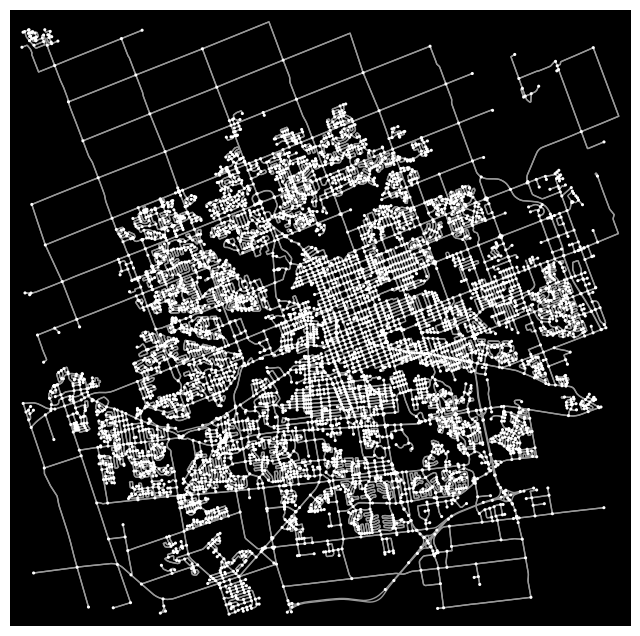

In [5]:
G=ox.graph_from_point(start, dist=10000, network_type="drive")
G=ox.add_edge_speeds(G)
G=ox.add_edge_travel_times(G)
fig,ax = ox.plot_graph(G, bgcolor="black", node_size=5 , node_color="white", figsize=(16,8))

In [7]:
start_node=ox.distance.nearest_nodes(G, start[1], start[0])
dtf["node"]=dtf[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
dtf=dtf.drop_duplicates("node", keep='first')
dtf.head()

C:\Users\ahmad\AppData\Local\Temp\ipykernel_40628\2197898139.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtf["node"]=dtf[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
C:\Users\ahmad\AppData\Local\Temp\ipykernel_40628\2197898139.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtf["node"]=dtf[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
C:\Users\ahmad\AppData\Local\Temp\ipykernel_40628\2197898139.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels 

id    City                                     Street Address      y  \
0   0  London                           265 Wharncliffe Rd North  42.99   
1   1  London                 1105 Wellington Rd., Store No. 122  42.93   
2   2  London                        631 Commissioners Road East  42.96   
3   3  London                            1442 Fanshawe Park Road  43.01   
4   4  London  580 Fanshawe Park Road East, Unit 1, White Oak...  43.03   

       x        node  
0 -81.26   289796441  
1 -81.22   324811692  
2 -81.23  4684790979  
3 -81.34   252974916  
4 -81.26   302754873

In [8]:
def f(a , b):
    try:
        d=nx.shortest_path_length(G, source=a, target=b, method='dijkstra', weight='travel_time')
    except:
        d=np.nan
    return d

distance_matrix=np.asarray([[f(a,b)for b in dtf["node"].tolist()] for a in dtf["node"].tolist()])
distance_matrix=pd.DataFrame(distance_matrix, columns=dtf["node"].values, index=dtf["node"].values)

distance_matrix.head()

289796441   324811692   4684790979  252974916   302754873   \
289796441          0.0       528.7       307.5       593.2       498.9   
324811692        575.1         0.0       222.1      1096.9       945.8   
4684790979       353.0       221.2         0.0       896.0       723.7   
252974916        592.2      1095.6       890.5         0.0       431.9   
302754873        499.0       944.9       723.7       432.7         0.0   

            305539079   347554420   4727288804  2600781784  1556562903  \
289796441        398.5        90.2       390.3       552.1        89.9   
324811692        707.4       454.7       854.6       733.8       476.2   
4684790979       551.9       232.6       632.5       560.9       254.1   
252974916        839.9       682.4       323.3       480.7       664.0   
302754873        465.2       551.4       110.8       893.0       512.8   

            1606842225  295523341   313507828   1609033105  312125272   \
289796441        513.0       429.7       229.5       165.1       530.3   
324811692        400.9       880.1       655.4       401.1       659.6   
4684790979       419.4       707.2       433.3       179.0       519.4   
252974916        725.2       353.9       499.0       748.1      1059.6   
302754873        867.7       762.0       347.8       554.3       684.9   

            260890490   311486306   3058247625  347336428   7271237232  
289796441        225.0       499.5       476.1      1033.9      1021.9  
324811692        768.7       111.2       979.8      1308.2       769.7  
4684790979       555.1       242.8       778.9      1165.7       916.1  
252974916        431.6      1016.9       173.1      1232.4       972.8  
302754873        394.6       949.6       315.6       857.7      1384.2

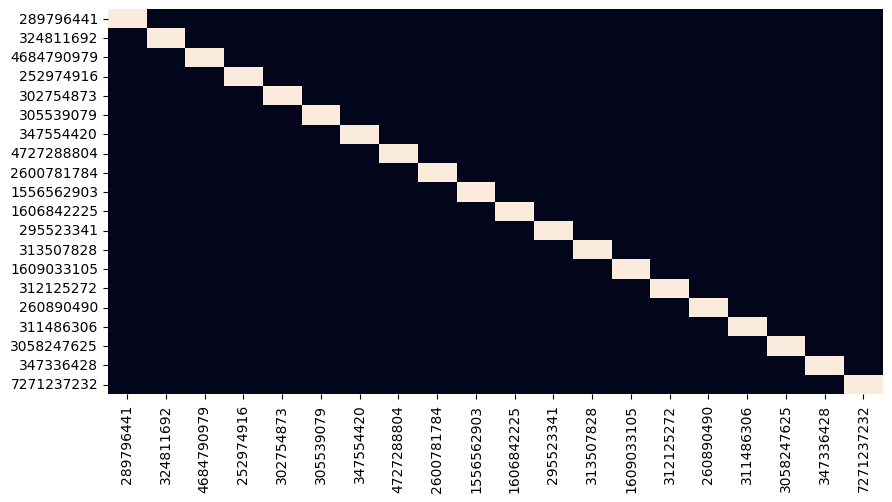

In [9]:
heatmap= distance_matrix.copy()
for col in heatmap.columns:
    heatmap[col]=heatmap[col].apply(lambda x: 
         0.3 if pd.isnull(x) else
         (0.7 if np.isinf(x) else 
          (0 if x!=0 else 1)) )
    
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(heatmap, vmin=0 , vmax=1 , cbar=False, ax=ax)
plt.show()

In [10]:
distance_matrix= distance_matrix.round()
distance_matrix=distance_matrix.astype('int')
distance_matrix

289796441   324811692   4684790979  252974916   302754873   \
289796441            0         529         308         593         499   
324811692          575           0         222        1097         946   
4684790979         353         221           0         896         724   
252974916          592        1096         891           0         432   
302754873          499         945         724         433           0   
305539079          399         638         554         841         467   
347554420          128         451         230         692         551   
4727288804         388         852         631         322         111   
2600781784         553         731         560         477         889   
1556562903         152         475         253         666         511   
1606842225         514         374         409         744         886   
295523341          428         881         695         354         762   
313507828          230         654         432         501         346   
1609033105         211         401         180         753         560   
312125272          579         596         521        1057         683   
260890490          224         750         529         431         394   
311486306          536         109         246        1018         948   
3058247625         475         979         773         173         315   
347336428         1031        1242        1167        1231         857   
7271237232        1022         772         917         973        1384   

            305539079   347554420   4727288804  2600781784  1556562903  \
289796441          398          90         390         552          90   
324811692          707         455         855         734         476   
4684790979         552         233         632         561         254   
252974916          840         682         323         481         664   
302754873          465         551         111         893         513   
305539079            0         410         519         890         372   
347554420          409           0         442         515          70   
4727288804         519         441           0         782         402   
2600781784         886         517         781           0         580   
1556562903         370          71         403         578           0   
1606842225         880         478         777         381         541   
295523341          759         494         654         182         518   
313507828          387         242         238         721         203   
1609033105         392          91         489         572         111   
312125272          296         481         735         986         475   
260890490          554         314         285         566         314   
311486306          764         417         839         655         461   
3058247625         723         565         206         633         547   
347336428          683        1043         909        1522        1005   
7271237232        1381         986        1276         625        1049   

            1606842225  295523341   313507828   1609033105  312125272   \
289796441          513         430         230         165         530   
324811692          401         880         655         401         660   
4684790979         419         707         433         179         519   
252974916          725         354         499         748        1060   
302754873          868         762         348         554         685   
305539079          865         759         389         389         296   
347554420          476         497         243          88         481   
4727288804         757         651         237         489         738   
2600781784         360         176         717         566         970   
1556562903         539         521         203         111         476   
1606842225           0         528         714         526         923   
295523341     

In [11]:
drivers = 1 
lst_nodes= dtf["node"].tolist()
print("start:", start_node, "total locations to visit", len(lst_nodes)-1, "drivers", drivers)

start: 289796441 total locations to visit 19 drivers 1


In [12]:
manager= pywrapcp.RoutingIndexManager(len(lst_nodes), drivers, lst_nodes.index(start_node))
model=pywrapcp.RoutingModel(manager)

In [13]:
def get_distance(from_index, to_index):
    return distance_matrix.iloc[from_index, to_index]

distance=model.RegisterTransitCallback(get_distance)
model.SetArcCostEvaluatorOfAllVehicles(distance)

parameters = pywrapcp.DefaultRoutingSearchParameters()
parameters.first_solution_strategy= (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

In [14]:
solution= model.SolveWithParameters(parameters)

index=model.Start(0)
print('route for driver:')
route_idx, route_distance = [], 0

while not model.IsEnd(index):
    route_idx.append(manager.IndexToNode(index))
    previous_index=index
    index=solution.Value(model.NextVar(index))
    
    try:
        route_distance +=get_distance(previous_index, index)
    except:
        route_distance+=model.GetArcCostForVehicle(from_index=previous_index, to_index=index, vehicle=0)
        
print(route_idx)
print(f'Total distance:{round(route_distance/1000,2)}km')
print(f'Nodes visited: {len(route_idx)}')

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000002B75C859730>>
Traceback (most recent call last):
  File "C:\Users\ahmad\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 785, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
                                                 ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ahmad\AppData\Local\Programs\Python\Python312\Lib\threading.py", line 1542, in enumerate
    with _active_limbo_lock:
SystemError: <built-in method __enter__ of _thread.RLock object at 0x000002B75720ED00> returned a result with an exception set
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000002B75C859730>>
Traceback (most recent call last):
  File "C:\Users\ahmad\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line

route for driver:
[0, 5, 12, 7, 17, 3, 11, 8, 10, 16, 1, 2, 13, 9, 6, 4, 15, 14, 18, 19]
Total distance:7.61km
Nodes visited: 20


In [15]:
print("Route for driver (nodes):")
lst_route=[lst_nodes[i] for i in route_idx]
print(lst_route)

Route for driver (nodes):
[289796441, 305539079, 313507828, 4727288804, 3058247625, 252974916, 295523341, 2600781784, 1606842225, 311486306, 324811692, 4684790979, 1609033105, 1556562903, 347554420, 302754873, 260890490, 312125272, 347336428, 7271237232]


In [16]:
def get_path_between_nodes(lst_route):
    lst_paths=[]
    for i in range (len(lst_route)):
        try :
            a , b = lst_nodes[i], lst_nodes[i+1]
        except:
            break
        try:
            path=nx.shortest_path(G, source=a, target=b, method ='dijkstra', weight='travel_time')
            if len(path) > 1:
                lst_paths.append(path)
        except:
            continue
    return lst_paths

lst_paths= get_path_between_nodes(lst_route)

for path in lst_paths:
    ox.plot_route_folium(G, route=path, route_map=map, color="blue", weight=1)
    
map

C:\Users\ahmad\AppData\Local\Temp\ipykernel_40628\1296747685.py:19: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  ox.plot_route_folium(G, route=path, route_map=map, color="blue", weight=1)
C:\Users\ahmad\AppData\Local\Temp\ipykernel_40628\1296747685.py:19: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  ox.plot_route_folium(G,

In [17]:
def df_animation_multiple_path(G, lst_paths, parallel=True):
    df=pd.DataFrame()
    for path in lst_paths :
        lst_start, lst_end = [] , []
        start_x, start_y = [] , []
        end_x, end_y = [], []
        lst_length, lst_time = [], [] 
        
        for a , b in zip (path[:-1], path[1:]):
            lst_start.append(a)
            lst_end.append(b)
            lst_length.append(round(G.edges[(a,b,0)]['length']))
            lst_time.append(round(G.edges[(a,b,0)]['travel_time']))
            start_x.append(G.nodes[a]['x'])
            start_y.append(G.nodes[a]['y'])
            end_x.append(G.nodes[b]['x'])
            end_y.append(G.nodes[b]['y'])
            
        tmp=pd.DataFrame(list(zip(lst_start, lst_end, start_x, start_y, end_x, end_y, lst_length, lst_time)), 
                         columns= ["start", "end", "start_x", "start_y", "end_x", "end_y", "length", "travel_time"])
        df=pd.concat([df,tmp], ignore_index=(not parallel))
        
    df=df.reset_index().rename(columns={"index":"id"})
    return df
            

In [18]:
df= pd.DataFrame()
tmp=df_animation_multiple_path(G, lst_paths, parallel=False)
df=pd.concat([df, tmp], axis=0)
first_node, last_node= lst_paths[0][0], lst_paths[-1][-1]

In [19]:
df_start= df[df["start"]== first_node]
df_end=df[df["end"]== last_node]

fig=px.scatter_mapbox(data_frame=df, lon="start_x", lat="start_y", zoom=15, width=900, height=700, animation_frame="id",mapbox_style="carto-positron")

fig.data[0].marker={"size":12}

fig.add_trace(px.scatter_mapbox(data_frame=dtf, lon="x", lat="y").data[0])
fig.data[1].marker={"size":10, "color":"black"}

fig.add_trace(px.scatter_mapbox(data_frame=df_start, lon="start_x", lat="start_y").data[0])
fig.data[2].marker={"size":15, "color":"red"}

fig.add_trace(px.scatter_mapbox(data_frame=df_end, lon="start_x", lat="start_y").data[0])
fig.data[3].marker={"size":15, "color":"green"}

fig.add_trace(px.line_mapbox(data_frame=df, lon="start_x", lat="start_y").data[0])

fig



ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'id=0<br>start_y=%{lat}<br>start_x=%{lon}<extra></extra>',
              'lat': array([42.9892556]),
              'legendgroup': '',
              'lon': array([-81.2603986]),
              'marker': {'size': 12},
              'mode': 'markers',
              'name': '',
              'showlegend': False,
              'subplot': 'mapbox',
              'type': 'scattermapbox'},
             {'hovertemplate': 'y=%{lat}<br>x=%{lon}<extra></extra>',
              'lat': array([42.99, 42.93, 42.96, 43.01, 43.03, 43.01, 42.98, 43.03, 42.96, 42.99,
                            42.94, 42.97, 43.01, 42.98, 43.  , 43.  , 42.94, 43.02, 51.46, 37.11]),
              'legendgroup': '',
              'lon': array([-81.26, -81.22, -81.23, -81.34, -81.26, -81.21, -81.25, -81.28, -81.33,
                            -81.25, -81.28, -81.32, -81.26, -81.24, -81.18, -81.28, -81.23, -81.31,
                             -0.17, -84.1 ]),
              'marker': {'color': 'black', 'size': 10},
              'mode': 'markers',
              'name': '',
              'showlegend': False,
              'subplot': 'mapbox',
              'type': 'scattermapbox'},
             {'hovertemplate': 'start_y=%{lat}<br>start_x=%{lon}<extra></extra>',
              'lat': array([42.9892556]),
              'legendgroup': '',
              'lon': array([-81.2603986]),
              'marker': {'color': 'red', 'size': 15},
              'mode': 'markers',
              'name': '',
              'showlegend': False,
              'subplot': 'mapbox',
              'type': 'scattermapbox'},
             {'hovertemplate': 'start_y=%{lat}<br>start_x=%{lon}<extra></extra>',
              'lat': array([42.9145645]),
              'legendgroup': '',
              'lon': array([-81.3596724]),
              'marker': {'color': 'green', 'size': 15},
              'mode': 'markers',
              'name': '',
              'showlegend': False,
              'subplot': 'mapbox',
              'type': 'scattermapbox'},
             {'hovertemplate': 'start_y=%{lat}<br>start_x=%{lon}<extra></extra>',
              'lat': array([42.9892556, 42.9891886, 42.9890642, ..., 42.9122329, 42.915418 ,
                            42.9145645]),
              'legendgroup': '',
              'line': {'color': '#636efa'},
              'lon': array([-81.2603986, -81.2584447, -81.2576157, ..., -81.3370152, -81.3427366,
                            -81.3596724]),
              'mode': 'lines',
              'name': '',
              'showlegend': False,
              'subplot': 'mapbox',
              'type': 'scattermapbox'}],
    'frames': [{'data': [{'hovertemplate': 'id=0<br>start_y=%{lat}<br>start_x=%{lon}<extra></extra>',
                          'lat': array([42.9892556]),
                          'legendgroup': '',
                          'lon': array([-81.2603986]),
                          'marker': {'color': '#636efa'},
                          'mode': 'markers',
                          'name': '',
                          'showlegend': False,
                          'subplot': 'mapbox',
                          'type': 'scattermapbox'}],
                'name': '0'},
               {'data': [{'hovertemplate': 'id=1<br>start_y=%{lat}<br>start_x=%{lon}<extra></extra>',
                          'lat': array([42.9891886]),
                          'legendgroup': '',
                          'lon': array([-81.2584447]),
                          'marker': {'color': '#636efa'},
                          'mode': 'markers',
                          'name': '',
                          'showlegend': False,
                          'subplot': 'mapbox',
                          'type': 'scattermapbox'}],
                'name': '1'},
               {'data': [{'hovertemplate': 'id=2<br>start_y=%{lat}<br>start_x=%{lon}<extra></extra>',
                          'lat': array([42.9890642]),
                          'legendgroup': '',
    